<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
import datasets
datasets.__version__

'2.18.0'

In [ ]:
# !pip install --proxy socks5://localhost:8765 datasets==2.18

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
from string import punctuation

In [ ]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error Tunnel connection
[nltk_data]     failed: 407 Proxy Authentication Required>


False

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
import os
os.environ['all_proxy'] = "socks5://localhost:8765"

In [ ]:
# Загрузим датасет
dataset = load_dataset("imdb", split="train")

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sample in tqdm(dataset):
    tmp = sent_tokenize(sample['text'])
    tmp = [s.lower() for s in tmp] #.translate(str.maketrans('', '', punctuation))
    for sentence in [word_tokenize(s) for s in tmp if len(word_tokenize(s)) < word_threshold]:
        sentences.append(sentence)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


Посчитаем для каждого слова его встречаемость.

In [ ]:
%%time
# Расчет встречаемости слов
words = Counter([i for j in sentences for i in j])

CPU times: total: 438 ms
Wall time: 431 ms


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
for w in tqdm([k for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)][:vocab_size]):
    vocab.add(w)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        processed_text = self.data[idx]

        tokenized_sentence += [word2ind.get(word, self.unk_id)
                               for word in processed_text]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
test_sentences, eval_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 1000

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1)) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
def train_model(model, train_dataloader, num_epoch=5):
    best_score = 10**6
    losses = []
    acc = []
    perplexities = []
    criterion=nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer=torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        score = evaluate(model, criterion, eval_dataloader)
        perplexities.append(score)
        if score < best_score:
                best_score = score

        # очищает выход ячейки, за счет чего вижу анимацию по эпохам
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(np.arange(len(losses)), losses, marker='o')
        ax1.set(title='Losses')
        plt.xlabel("epoch")
        ax2.plot(np.arange(len(perplexities)), perplexities, marker='o')
        ax2.set(title='Perplexity')
        plt.xlabel("epoch")
        plt.show()

    return model, best_score, losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class WordGRU(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        # output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

def generate_sequence(model, starting_seq: str, max_seq_len: int = 32) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in starting_seq.split()]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [ ]:
from IPython.display import clear_output
from collections import defaultdict

In [ ]:
device

'cuda'

In [ ]:
model = WordGRU(hidden_dim=256, vocab_size=len(vocab)).to(device)

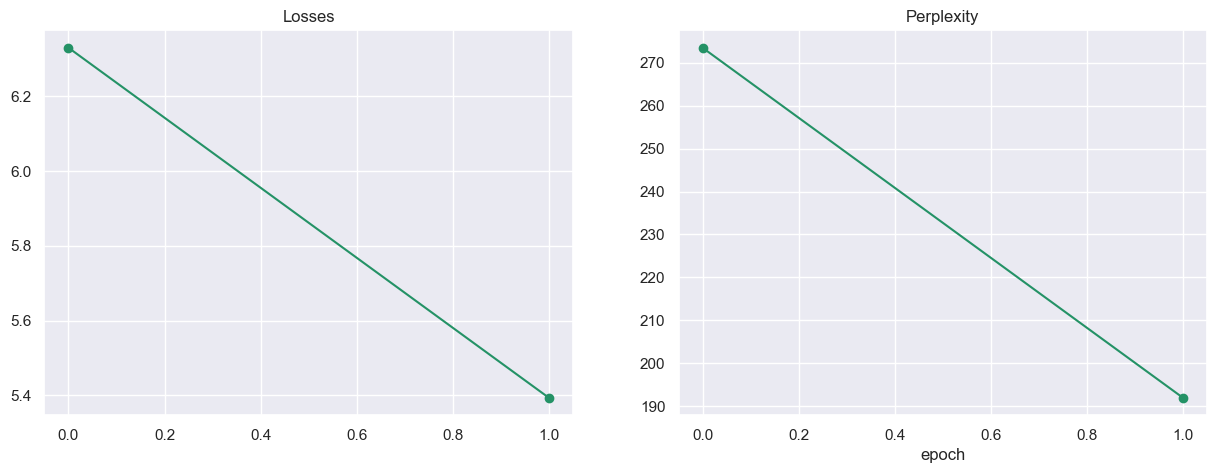

CPU times: total: 6min 59s
Wall time: 12min 36s


In [ ]:
%%time
model, best_base_metric, losses, perplexities = train_model(model, train_dataloader, num_epoch=2)

In [ ]:
best_base_metric

191.99947662353514

In [ ]:
torch.save(model, f'models/base_rnn_{best_base_metric}.pt')

In [ ]:
model = torch.load('models/base_rnn_191.50241394042968.pt')

In [ ]:
generate_sequence(model, starting_seq='when i was a')

'<bos> when i was a self-conscious sylvia quick-witted transformations granpa granpa upstate wrench quick-draw hodges charger verges self-conscious sylvia obscura transformations granpa granpa upstate wrench quick-draw hodges charger verges self-conscious sylvia obscura transformations granpa granpa upstate wrench'

In [ ]:
del model
torch.cuda.empty_cache()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
class WordBiLSTM_BN(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.bn(self.non_lin(output)))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
class WordBiLSTM_LogSoftmax(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
class WordBiLSTM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
class WordLSTM_ReLU(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
class WordLSTM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 1000

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

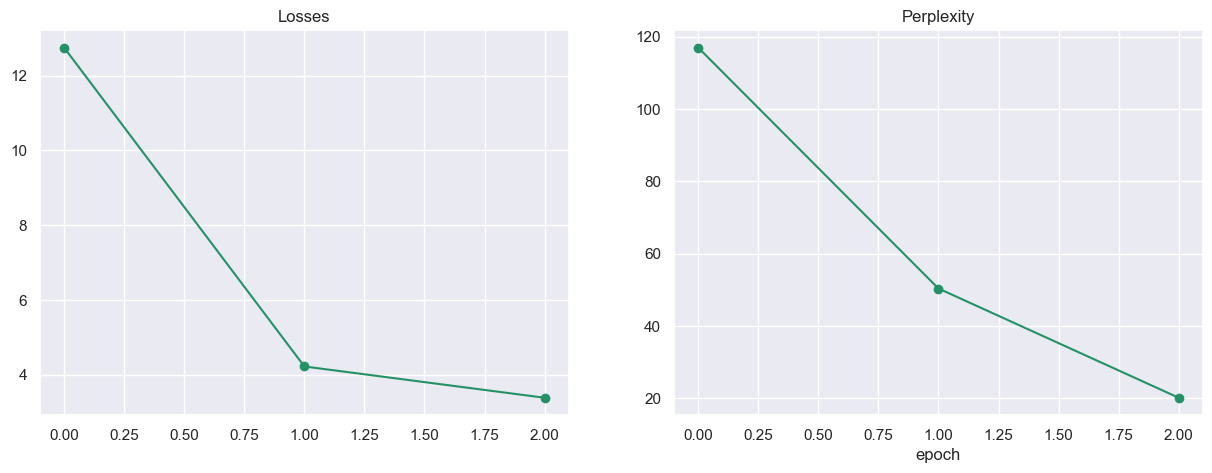

CPU times: total: 3h 44min 54s
Wall time: 5h 2min 26s


In [ ]:
%%time
results = defaultdict(list)

best_of_best = best_base_metric

for arch in tqdm([WordGRU, WordLSTM, WordLSTM_ReLU, WordBiLSTM, WordBiLSTM_BN, WordBiLSTM_LogSoftmax], position=0, leave=True):
    for hidden_dim in [128, 256, 512]:
        print(arch.__name__)
        results['class'].append(arch.__name__)
        model = arch(hidden_dim=hidden_dim, vocab_size=len(vocab)).to(device)
        model, best_metric, losses, perplexities = train_model(model, train_dataloader, num_epoch=3)
        results['best_metric'].append(best_metric)
        results['losses'].append(losses)
        results['perplexities'].append(perplexities)
        results['hidden_dim'].append(hidden_dim)
        results['sample'].append(generate_sequence(model, starting_seq='when i was a'))
        if best_metric < best_base_metric:
            torch.save(model, f'models/{arch.__name__}_{hidden_dim}_{best_metric}.pt')
        del model
        torch.cuda.empty_cache()

In [ ]:
import pandas as pd
df_result = pd.DataFrame(results)

In [ ]:
df_result['sample']

0           <bos> when i was a lot of the movie . <eos>
1                 <bos> when i was a good movie . <eos>
2            <bos> when i was a fan of the film . <eos>
3                      <bos> when i was a <unk> . <eos>
4                 <bos> when i was a good movie . <eos>
5           <bos> when i was a fan of the movie . <eos>
6                       <bos> when i was a good . <eos>
7                 <bos> when i was a good movie . <eos>
8           <bos> when i was a lot of the movie . <eos>
9     <bos> when i was a have have have have have ha...
10    <bos> when i was a hope attractive slow attrac...
11    <bos> when i was a clue toward toward toward t...
12    <bos> when i was a andreas ajax well-rounded c...
13    <bos> when i was a weak element element elemen...
14    <bos> when i was a considerable considerable c...
15    <bos> when i was a good good good good good go...
16    <bos> when i was a big big big big big big big...
17    <bos> when i was a good good movie that th

In [ ]:
model = torch.load('models/WordBiLSTM_BN_512_1.048949259519577.pt')

In [ ]:
generate_sequence(model, 'the film was', 32)

'<bos> the film was caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring caring'

In [ ]:
model = torch.load('models/WordGRU_512_120.56838417053223.pt')

In [ ]:
generate_sequence(model, 'the film was', 32)

"<bos> the film was flicks humbly bi-sexual dudettes dudettes 'tribe groaningly expanded back-drop fortuneately distinctively back-drop fortuneately distinctively back-drop fortuneately distinctively back-drop fortuneately distinctively back-drop fortuneately distinctively back-drop fortuneately distinctively back-drop fortuneately elegiac distinctively eager back-drop"

### Отчет (2 балла)

Текст был выделен строчными буквами, а знаки препинания не были удалены.

Испробовано:
- Изменения базового слоя (GRU, LSTM, BidirectionalLSTM)
- Функции активации (Tanh, ReLU, LogSoftmax)
- Размеры скрытого слоя (128, 256, 512)
- Пакетная нормализация


Bilstm значительно улучшил показатели (с 100+ до 20+), но конечный результат не нравится.

In [ ]:
df_result.sort_values('best_metric')

,class,best_metric,losses,perplexities,hidden_dim,sample
14,WordBiLSTM_BN,1.048949,"[1.6769027571193873, 0.06797040403471329, 0.00...","[1.2206207931041717, 1.0654442071914674, 1.048...",512,<bos> when i was a considerable considerable c...
13,WordBiLSTM_BN,1.061727,"[2.547537976130843, 0.20035671796649696, 0.035...","[1.597392052412033, 1.1232259631156922, 1.0617...",256,<bos> when i was a weak element element elemen...
11,WordBiLSTM,1.130886,"[3.658856464922428, 0.5278837418183684, 0.1590...","[2.7019976139068604, 1.2914586246013642, 1.130...",512,<bos> when i was a clue toward toward toward t...
12,WordBiLSTM_BN,1.147291,"[3.811568433791399, 0.5827981373295188, 0.1666...","[3.383697485923767, 1.3488839268684387, 1.1472...",128,<bos> when i was a andreas ajax well-rounded c...
10,WordBiLSTM,1.512327,"[5.181415812671185, 1.569058407843113, 0.62200...","[13.3029709815979, 2.3194469690322874, 1.51232...",256,<bos> when i was a hope attractive slow attrac...
9,WordBiLSTM,9.374864,"[6.643717557191849, 4.8454209342598915, 3.0054...","[296.9492874145508, 41.64226531982422, 9.37486...",128,<bos> when i was a have have have have have ha...
16,WordBiLSTM_LogSoftmax,11.325349,"[6.509533256292343, 4.189793799817562, 2.98134...","[122.58927383422852, 38.02282295227051, 11.325...",256,<bos> when i was a big big big big big big big...
15,WordBiLSTM_LogSoftmax,13.351781,"[6.439485684037209, 4.518109668791294, 3.20284...","[180.45160751342775, 47.31450977325439, 13.351...",128,<bos> when i was a good good good good good go...
17,WordBiLSTM_LogSoftmax,20.148784,"[12.742815831303597, 4.2230703547596935, 3.387...","[116.96376838684083, 50.361267471313475, 20.14...",512,<bos> when i was a good good movie that that '...
2,WordGRU,120.690134,"[5.861846339702606, 5.027308577299118, 4.75378...","[188.08006744384767, 140.21577072143555, 120.6...",512,<bos> when i was a fan of the film . <eos>
